In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [89]:


DIRECTORY = "./dataset"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [90]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [91]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.25,stratify=labels,random_state=42)

In [92]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [96]:
IMAGE_SIZE=[224,224]

mobilenet=MobileNetV2(input_shape=IMAGE_SIZE+[3],weights="imagenet",include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [101]:
x=Flatten()(mobilenet.output)
predictions=Dense(2,activation="softmax")(x)

In [103]:
for layer in mobilenet.layers:
  layer.trainable=False

In [105]:
model=Model(inputs=mobilenet.input,outputs=predictions)

In [107]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [118]:
opt = Adam(lr=1e-4, decay= 1e-4 / 20)
model.compile(loss="binary_crossentropy", 
              optimizer='adam',
              metrics=["accuracy"])


In [121]:
history = model.fit(
	aug.flow(train_data,train_labels, batch_size=32),
	steps_per_epoch=len(train_data) // 32,
	validation_data=(test_data, test_labels),
	validation_steps=len(test_data) // 32,
	epochs=10)


Epoch 1/10
90/90 [==============================] - 144s 2s/step - loss: 0.1769 - accuracy: 0.9870 - val_loss: 0.1384 - val_accuracy: 0.9865
Epoch 2/10
90/90 [==============================] - 144s 2s/step - loss: 0.1932 - accuracy: 0.9853 - val_loss: 0.4945 - val_accuracy: 0.9647
Epoch 3/10
90/90 [==============================] - 145s 2s/step - loss: 0.1911 - accuracy: 0.9849 - val_loss: 0.1388 - val_accuracy: 0.9886
Epoch 4/10
90/90 [==============================] - 144s 2s/step - loss: 0.1640 - accuracy: 0.9874 - val_loss: 0.2951 - val_accuracy: 0.9771
Epoch 5/10
90/90 [==============================] - 145s 2s/step - loss: 0.2787 - accuracy: 0.9797 - val_loss: 0.1507 - val_accuracy: 0.9886
Epoch 6/10
90/90 [==============================] - 145s 2s/step - loss: 0.1862 - accuracy: 0.9846 - val_loss: 0.2994 - val_accuracy: 0.9771
Epoch 7/10
90/90 [==============================] - 165s 2s/step - loss: 0.1318 - accuracy: 0.9905 - val_loss: 0.2455 - val_accuracy: 0.9823
Epoch 8/10
90

In [122]:
model.save("Face_Mask_Detection.h5")

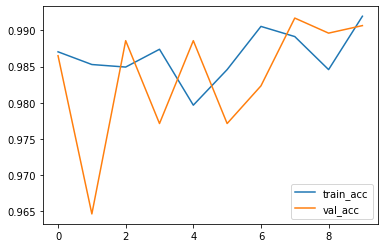

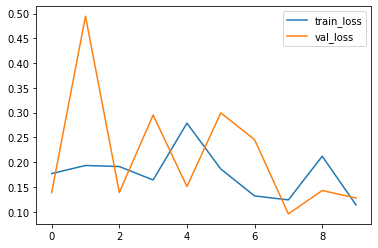

In [123]:
plt.plot(history.history['accuracy'],label="train_acc")
plt.plot(history.history['val_accuracy'],label="val_acc")
plt.legend()
plt.show()
#plt.savefig('model_acc')

plt.plot(history.history['loss'],label="train_loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.show()
#plt.savefig('model_loss')